### Imports

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from vae_model import VAE       
from vae_train import train_vae, validate_vae   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Dataloader

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_dataset   = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


### Init

In [3]:
latent_dim = 128
model = VAE(in_channel=3, latent_dim=latent_dim, input_size=64, encoder_type="conv", freeze_resnet=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)


### Train

In [ ]:
# epochs = 75
# train_losses, val_losses = [], []

# for epoch in range(1, epochs + 1):
#     train_loss = train_vae(model, train_loader, optimizer, device, epoch)
#     val_loss   = validate_vae(model, val_loader, device, epoch)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

Epoch 1 [0/50000 (0%)]	Loss: 8800.875000
====> Epoch: 1 Average loss: 8214.7701
====> Validation set loss: 7836.5222
Best checkpoint saved: vae_checkpoints/best_checkpoint.pth (val_loss=7836.522200)
Epoch 2 [0/50000 (0%)]	Loss: 7673.365234
====> Epoch: 2 Average loss: 7528.7490
====> Validation set loss: 7479.9577
Best checkpoint saved: vae_checkpoints/best_checkpoint.pth (val_loss=7479.957700)
Epoch 3 [0/50000 (0%)]	Loss: 7452.062988
====> Epoch: 3 Average loss: 7424.8948
====> Validation set loss: 7402.7207
Best checkpoint saved: vae_checkpoints/best_checkpoint.pth (val_loss=7402.720650)
Epoch 4 [0/50000 (0%)]	Loss: 7411.130859
====> Epoch: 4 Average loss: 7365.0541
====> Validation set loss: 7350.1414
Best checkpoint saved: vae_checkpoints/best_checkpoint.pth (val_loss=7350.141400)
Epoch 5 [0/50000 (0%)]	Loss: 7349.207031
====> Epoch: 5 Average loss: 7293.2295
====> Validation set loss: 7300.3064
Best checkpoint saved: vae_checkpoints/best_checkpoint.pth (val_loss=7300.306400)
Epoch

### Visualize

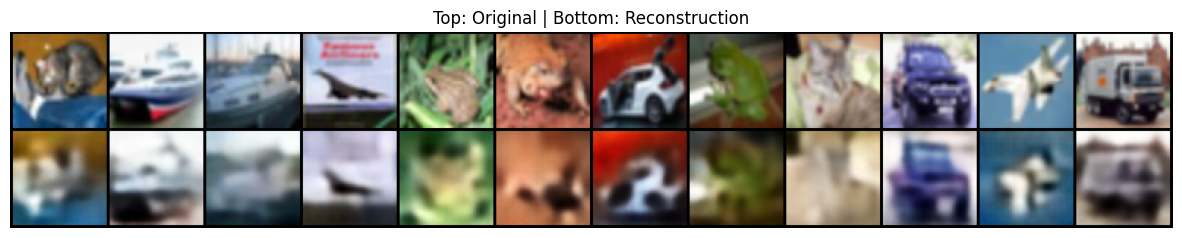

In [4]:
ckpt_path = "/mnt/truenas_smb/pacs/VAE-GANs/vae_checkpoints/best_checkpoint.pth"
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()
dataiter = iter(val_loader)
images, _ = next(dataiter)
images = images.to(device)

with torch.no_grad():
    recon_images, _, _ = model(images)

n = 12
comparison = torch.cat([images[:n], recon_images[:n]])
grid = vutils.make_grid(comparison.cpu(), nrow=n, normalize=True, scale_each=True)

plt.figure(figsize=(15, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis("off")
plt.title("Top: Original | Bottom: Reconstruction")
plt.show()


### Sampling

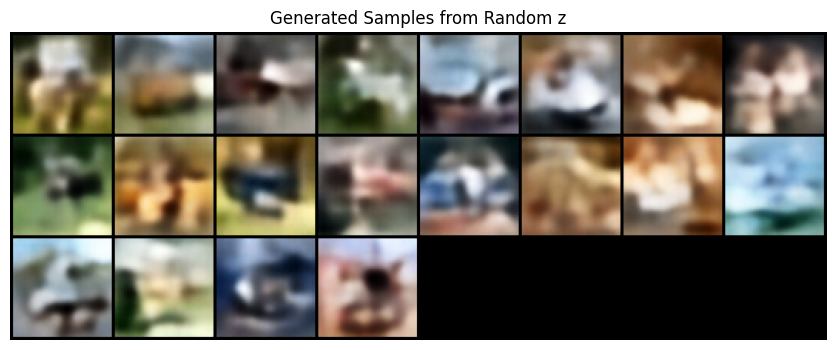

In [6]:
with torch.no_grad():
    # Sample random latent vectors from N(0,1)
    z = torch.randn(20, latent_dim).to(device)
    samples = model.decoder(z)

grid = vutils.make_grid(samples.cpu(), nrow=8, normalize=True, scale_each=True)
plt.figure(figsize=(12,4))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis("off")
plt.title("Generated Samples from Random z")
plt.show()


### Inception Score

In [6]:
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

def inception_score(imgs, batch_size=32, splits=10, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    imgs = imgs.clone().detach().cpu()
    if imgs.min() < -0.1:
        imgs = (imgs + 1.0) / 2.0
    imgs = imgs.clamp(0,1)
    N = imgs.shape[0]
    if N == 0:
        raise ValueError("Empty image tensor")
    if N < splits:
        splits = 1
    try:
        model = torchvision.models.inception_v3(aux_logits=False, pretrained=True).to(device).eval()
    except Exception:
        model = torchvision.models.inception_v3(aux_logits=True, pretrained=True).to(device).eval()
    ds = TensorDataset(imgs)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)
    preds = []
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
    with torch.no_grad():
        for (batch,) in dl:
            batch = batch.to(device)
            batch = F.interpolate(batch, size=(299,299), mode='bilinear', align_corners=False)
            batch = (batch - mean) / std
            out = model(batch)
            if isinstance(out, tuple):
                out = out[0]
            p = F.softmax(out, dim=1)
            preds.append(p.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    scores = []
    split_size = preds.shape[0] // splits
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size]
        py = np.mean(part, axis=0, keepdims=True)
        kl = part * (np.log(part + 1e-20) - np.log(py + 1e-20))
        kl_sum = np.sum(kl, axis=1)
        score = float(np.exp(np.mean(kl_sum)))
        scores.append(score)
    return float(np.mean(scores)), float(np.std(scores))

imgs_for_is = None
if 'recon_images' in globals():
    imgs_for_is = recon_images.cpu()
elif 'comparison' in globals():
    imgs_for_is = comparison.cpu()
elif 'images' in globals():
    imgs_for_is = images.cpu()
else:
    raise RuntimeError("No image tensor found. Place images in variable 'recon_images' or 'comparison' or 'images'")

mean_is, std_is = inception_score(imgs_for_is, batch_size=32, splits=10, device=device)
print("Inception Score: mean =", mean_is, " std =", std_is)


Inception Score: mean = 1.4644599437713623  std = 0.16347014996496745


### FID

In [7]:
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms.functional as TF

fid = FrechetInceptionDistance(feature=2048).to(device)

for images, _ in val_loader:
    images = TF.resize(images, (299, 299))
    images_uint8 = (images * 255).clamp(0, 255).to(torch.uint8).to(device)
    fid.update(images_uint8, real=True)

model.eval()
with torch.no_grad():
    for _ in range(10):
        z = torch.randn(1000, latent_dim).to(device)
        samples = model.decoder(z)
        samples = TF.resize(samples, (299, 299))
        fake_uint8 = ((samples + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fid.update(fake_uint8.to(device), real=False)

fid_score = fid.compute()
print(f"FID (VAE vs Real): {fid_score.item():.4f}")


FID (VAE vs Real): 125.6388


### Reconstruction Error

In [9]:
import torch.nn.functional as F

model.eval()
total_mse = 0
num_pixels = 0

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        recon, _, _ = model(images)
        mse = F.mse_loss(recon, images, reduction='sum')
        total_mse += mse.item()
        num_pixels += images.numel()  # total pixels in the batch

avg_mse_per_pixel = total_mse / num_pixels
print("VAE average reconstruction MSE per pixel:", avg_mse_per_pixel)


VAE average reconstruction MSE per pixel: 0.005271888966361681


### Interpolation

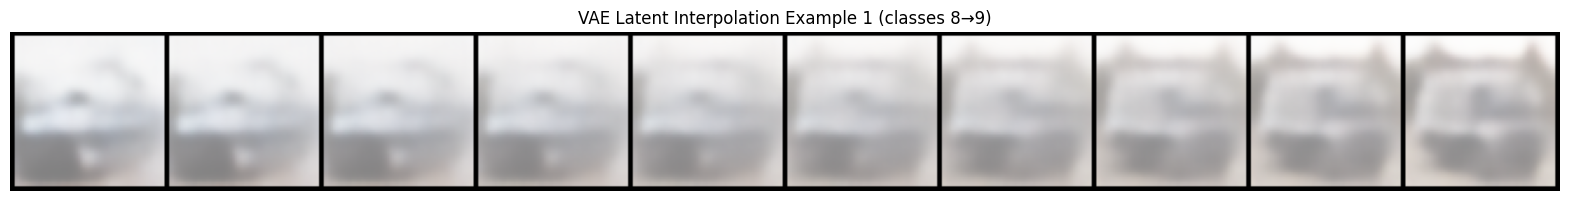

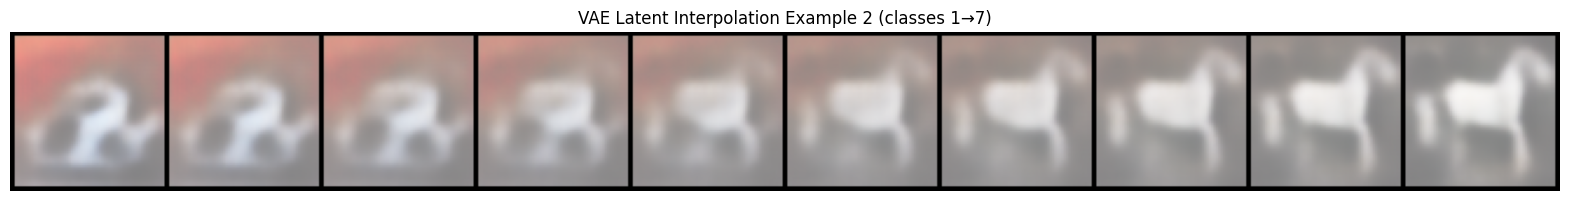

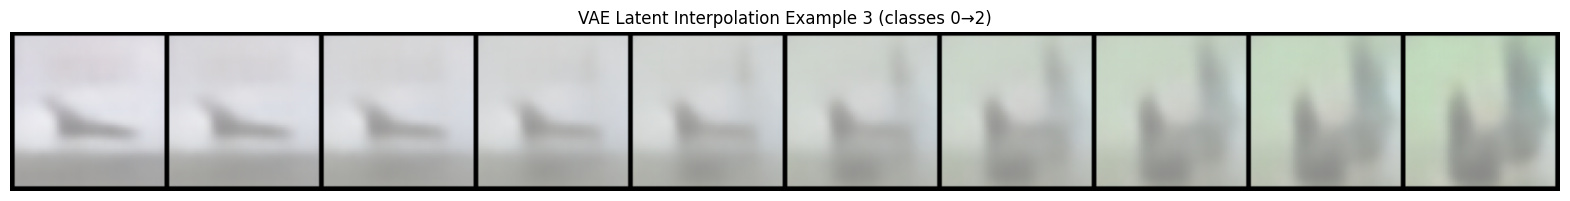

In [16]:
model.eval()
num_interpolations = 10
examples = [(8, 9), (1, 7), (0, 2)] 

for i, (class_a, class_b) in enumerate(examples):
    images, labels = next(iter(val_loader))
    idx1 = (labels == class_a).nonzero(as_tuple=True)[0][0]
    idx2 = (labels == class_b).nonzero(as_tuple=True)[0][0]

    img1 = images[idx1].unsqueeze(0).to(device)
    img2 = images[idx2].unsqueeze(0).to(device)

    with torch.no_grad():
        mu1, logvar1 = model.encoder(img1)
        mu2, logvar2 = model.encoder(img2)
        z1 = mu1
        z2 = mu2

    interpolated_z = [z1 * (1 - alpha) + z2 * alpha for alpha in torch.linspace(0, 1, num_interpolations).to(device)]
    interpolated_z = torch.cat(interpolated_z, dim=0)

    with torch.no_grad():
        interpolated_imgs = model.decoder(interpolated_z)

    interpolated_imgs = (interpolated_imgs + 1) / 2
    interpolated_imgs = torch.clamp(interpolated_imgs, 0, 1)

    grid = vutils.make_grid(interpolated_imgs.cpu(), nrow=num_interpolations, padding=2)
    plt.figure(figsize=(20,4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"VAE Latent Interpolation Example {i+1} (classes {class_a}→{class_b})")
    plt.show()


### Latent Representation Analysis

Extracting latents: 100%|██████████| 313/313 [00:03<00:00, 89.42it/s]


Latent shape: (10000, 128) Labels: (10000,)
PCA variance retained: 0.60555536


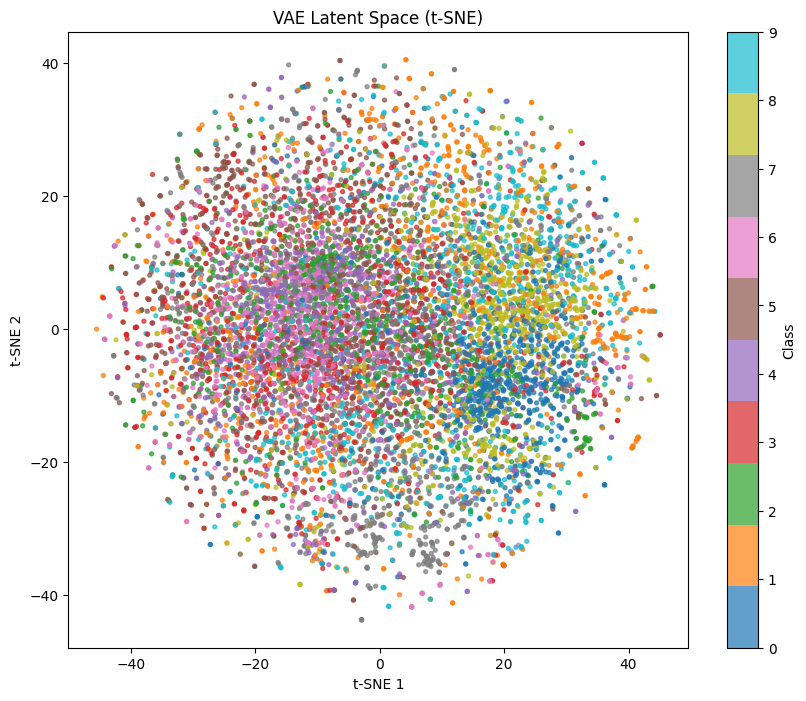

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

model.eval()
latents = []
labels = []

with torch.no_grad():
    for imgs, labs in tqdm(val_loader, desc="Extracting latents"):
        imgs = imgs.to(device)
        _, mu, _ = model(imgs)
        latents.append(mu.cpu().numpy())
        labels.append(labs.cpu().numpy())

Z = np.concatenate(latents, axis=0)
L = np.concatenate(labels, axis=0)
print("Latent shape:", Z.shape, "Labels:", L.shape)

pca = PCA(n_components=min(50, Z.shape[1]))
Z_pca = pca.fit_transform(Z)
print("PCA variance retained:", pca.explained_variance_ratio_.sum())

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, init='pca')
Z_tsne = tsne.fit_transform(Z_pca)

plt.figure(figsize=(10,8))
scatter = plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=L, s=8, cmap='tab10', alpha=0.7)
plt.title("VAE Latent Space (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=np.unique(L), label="Class")
plt.show()


### Latent Traversal

/tmp/ipykernel_822112/2340795810.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)  # Minimize padding


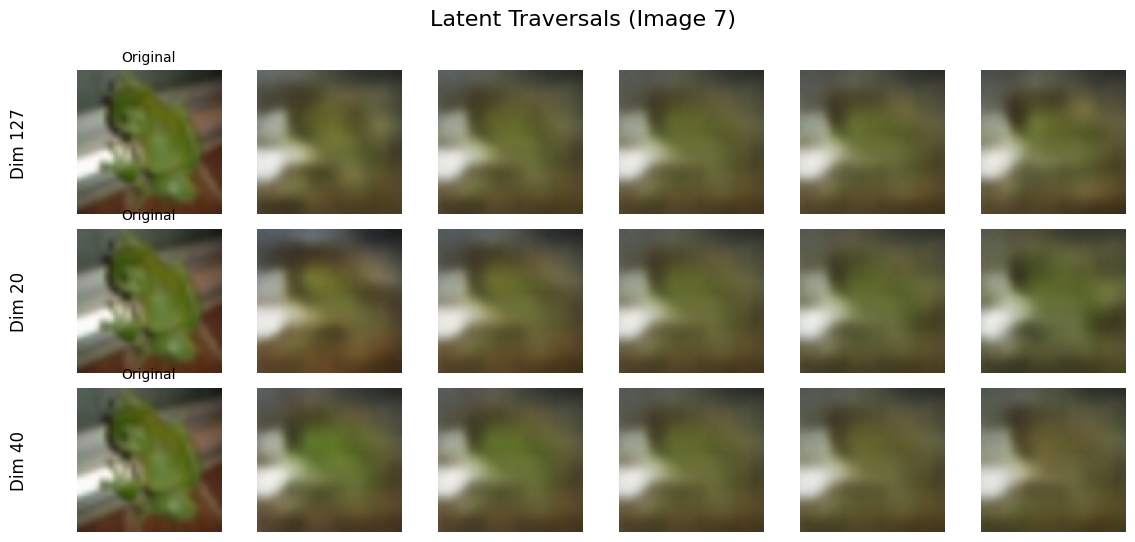

In [24]:
import torch
import matplotlib.pyplot as plt

def latent_traversal_single(model, image, dim_indices, steps=7, span=3.0, device="cuda"):
    model.eval()
    rows = []
    with torch.no_grad():
        img = image.unsqueeze(0).to(device)
        _, mu, _ = model(img)
        mu = mu[0].clone()
        values = torch.linspace(-span, span, steps)
        for dim_idx in dim_indices:
            decoded = []
            for v in values:
                z = mu.clone()
                z[dim_idx] += v
                recon = model.decoder(z.unsqueeze(0))
                decoded.append(recon.cpu())
            decoded = torch.cat(decoded, dim=0)
            rows.append(decoded)
    return rows

# Just take image 7
images, _ = next(iter(val_loader))
img7 = images[7]

dim_indices = [127, 20, 40]
decoded_rows = latent_traversal_single(model, img7, dim_indices, steps=5, span=3.0, device=device)

# -------------------------------
# Plot: original + traversals
# -------------------------------
fig, axes = plt.subplots(len(decoded_rows), len(decoded_rows[0]) + 1, 
                        figsize=(14, 2 * len(decoded_rows)), 
                        gridspec_kw={'wspace': 0, 'hspace': 0.1})

for r, row in enumerate(decoded_rows):
    # Original image
    axes[r, 0].imshow(img7.permute(1, 2, 0).clamp(0, 1))
    axes[r, 0].set_title("Original", fontsize=10)
    axes[r, 0].axis("off")
    
    # Add dimension label on the left
    axes[r, 0].text(-30, img7.shape[1]//2, 
                    f"Dim {dim_indices[r]}", 
                    fontsize=12, 
                    rotation=90, 
                    va="center")

    # Traversals
    for c in range(row.size(0)):
        ax = axes[r, c + 1]
        ax.imshow(row[c].permute(1, 2, 0).clamp(0, 1))
        ax.axis("off")

plt.suptitle("Latent Traversals (Image 7)", fontsize=16)
plt.tight_layout(pad=0)  # Minimize padding
plt.show()

### OOD

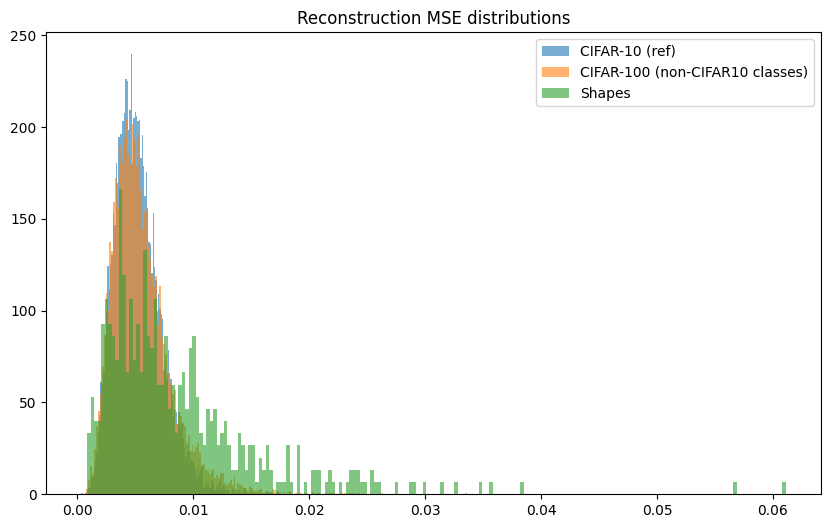

AUC CIFAR-10 vs CIFAR-100 (non-CIFAR10 classes) (recon MSE): 0.5154287200000001
AUC CIFAR-10 vs Shapes (recon MSE): 0.6499756000000001


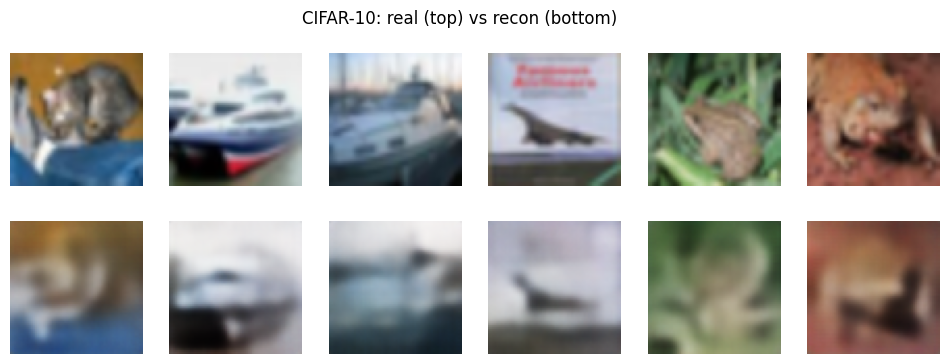

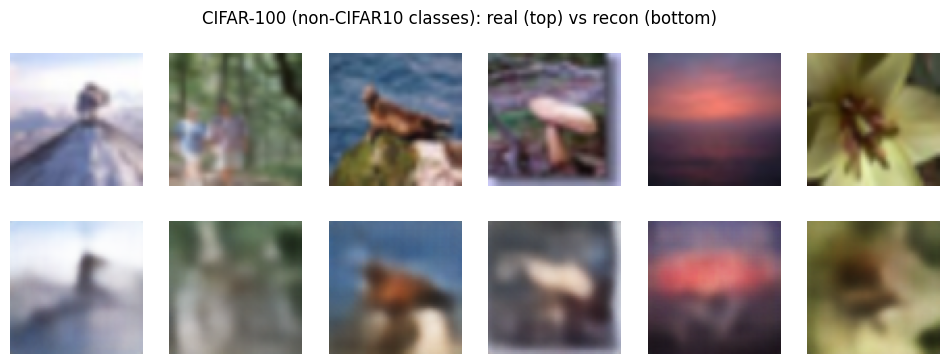

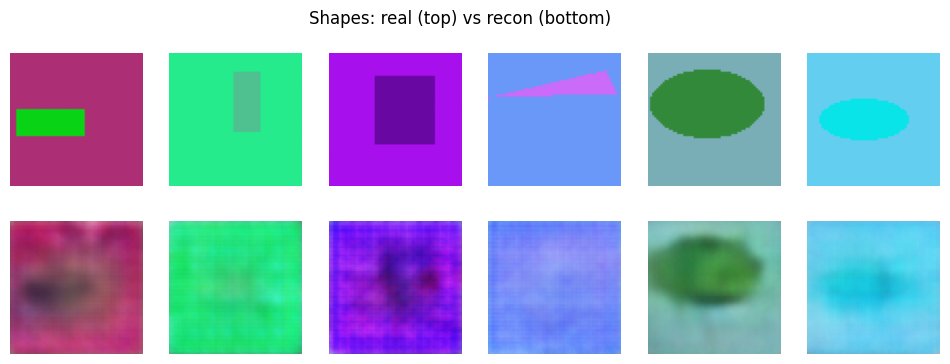

In [53]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, Dataset

device = device if 'device' in globals() else ("cuda" if torch.cuda.is_available() else "cpu")

def get_val_transform_from_loader(loader):
    try:
        return loader.dataset.transform
    except Exception:
        return T.ToTensor()

val_transform = get_val_transform_from_loader(val_loader)

def make_loader_from_dataset(dataset, batch_size=128, num_workers=4):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

cifar10_classes = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

c100_all = torchvision.datasets.CIFAR100(root="./data", train=False, download=True)
c100_classes = c100_all.classes
non_cifar10_classes = [c for c in c100_classes if c not in cifar10_classes]
non_cifar10_indices = [c100_classes.index(c) for c in non_cifar10_classes]

class CIFAR100Filtered(torchvision.datasets.CIFAR100):
    def __init__(self, root, train=False, transform=None, download=True, valid_indices=None):
        super().__init__(root=root, train=train, transform=transform, download=download)
        if valid_indices is not None:
            mask = np.isin(self.targets, valid_indices)
            self.data = self.data[mask]
            self.targets = np.array(self.targets)[mask].tolist()

cifar100_non10 = CIFAR100Filtered(root="./data", train=False, transform=val_transform, download=True, valid_indices=non_cifar10_indices)
cifar100_loader = make_loader_from_dataset(cifar100_non10)
cifar10_loader = val_loader

class SyntheticShapes(Dataset):
    def __init__(self, n=500, size=(32,32), transform=None):
        self.n = n
        self.size = size
        self.transform = transform or T.ToTensor()
        self.imgs = [self._make_img(i) for i in range(n)]
    def _make_img(self, seed):
        rng = np.random.RandomState(seed)
        img = Image.new("RGB", self.size, (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
        draw = ImageDraw.Draw(img)
        shape_type = rng.choice(["rect","ellipse","line","triangle"])
        if shape_type == "rect":
            x0,y0 = rng.randint(0,self.size[0]//2), rng.randint(0,self.size[1]//2)
            x1,y1 = rng.randint(self.size[0]//2,self.size[0]-1), rng.randint(self.size[1]//2,self.size[1]-1)
            draw.rectangle([x0,y0,x1,y1], fill=(rng.randint(0,256),rng.randint(0,256),rng.randint(0,256)))
        elif shape_type == "ellipse":
            x0,y0 = rng.randint(0,self.size[0]//2), rng.randint(0,self.size[1]//2)
            x1,y1 = rng.randint(self.size[0]//2,self.size[0]-1), rng.randint(self.size[1]//2,self.size[1]-1)
            draw.ellipse([x0,y0,x1,y1], fill=(rng.randint(0,256),rng.randint(0,256),rng.randint(0,256)))
        elif shape_type == "line":
            pts = [(rng.randint(0,self.size[0]-1), rng.randint(0,self.size[1]-1)) for _ in range(3)]
            draw.line(pts, fill=(rng.randint(0,256),rng.randint(0,256),rng.randint(0,256)), width=3)
        else:
            p1 = (rng.randint(0,self.size[0]-1), rng.randint(0,self.size[1]-1))
            p2 = (rng.randint(0,self.size[0]-1), rng.randint(0,self.size[1]-1))
            p3 = (rng.randint(0,self.size[0]-1), rng.randint(0,self.size[1]-1))
            draw.polygon([p1,p2,p3], fill=(rng.randint(0,256),rng.randint(0,256),rng.randint(0,256)))
        return img
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        img = self.imgs[idx]
        return self.transform(img), 0

img_h = val_loader.dataset[0][0].shape[1]
img_w = val_loader.dataset[0][0].shape[2]
shape_ds = SyntheticShapes(n=500, size=(img_h, img_w), transform=val_transform)
shape_loader = make_loader_from_dataset(shape_ds)

def compute_recon_errors_vae(model, loader, max_batches=None):
    model.eval()
    errors = []
    examples_real = []
    examples_recon = []
    with torch.no_grad():
        for bidx, (imgs, _) in enumerate(loader):
            imgs = imgs.to(device)
            recon, mu, logvar = model(imgs)
            mse = ((recon - imgs) ** 2).view(imgs.size(0), -1).mean(dim=1)
            errors.append(mse.cpu().numpy())
            if len(examples_real) < 8:
                for i in range(min(8, imgs.size(0))):
                    examples_real.append(imgs[i].cpu())
                    examples_recon.append(recon[i].cpu())
            if max_batches and bidx+1 >= max_batches:
                break
    errors = np.concatenate(errors, axis=0)
    return errors, examples_real, examples_recon

errors_c10, exr_c10, exre_c10 = compute_recon_errors_vae(model, cifar10_loader)
errors_c100_non10, exr_c100_non10, exre_c100_non10 = compute_recon_errors_vae(model, cifar100_loader)
errors_shape, exr_shape, exre_shape = compute_recon_errors_vae(model, shape_loader)

def plot_error_histograms(ref_err, ood_errs, labels):
    plt.figure(figsize=(10,6))
    plt.hist(ref_err, bins=200, alpha=0.6, label='CIFAR-10 (ref)', density=True)
    for err, lab in zip(ood_errs, labels):
        plt.hist(err, bins=200, alpha=0.6, label=lab, density=True)
    plt.legend()
    plt.title("Reconstruction MSE distributions")
    plt.show()

plot_error_histograms(errors_c10, [errors_c100_non10, errors_shape], ["CIFAR-100 (non-CIFAR10 classes)", "Shapes"])

def compute_auc(ref_err, ood_err):
    y_true = np.concatenate([np.zeros_like(ref_err), np.ones_like(ood_err)])
    scores = np.concatenate([ref_err, ood_err])
    return roc_auc_score(y_true, scores)

auc_c100_non10 = compute_auc(errors_c10, errors_c100_non10)
auc_shape = compute_auc(errors_c10, errors_shape)
print("AUC CIFAR-10 vs CIFAR-100 (non-CIFAR10 classes) (recon MSE):", auc_c100_non10)
print("AUC CIFAR-10 vs Shapes (recon MSE):", auc_shape)

def show_reconstruction_examples(real_examples, recon_examples, title):
    n = min(6, len(real_examples))
    plt.figure(figsize=(12,4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(torch.clamp(real_examples[i].permute(1,2,0), 0, 1))
        plt.axis("off")
        plt.subplot(2, n, i+1+n)
        plt.imshow(torch.clamp(recon_examples[i].permute(1,2,0), 0, 1))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_reconstruction_examples(exr_c10, exre_c10, "CIFAR-10: real (top) vs recon (bottom)")
show_reconstruction_examples(exr_c100_non10, exre_c100_non10, "CIFAR-100 (non-CIFAR10 classes): real (top) vs recon (bottom)")
show_reconstruction_examples(exr_shape, exre_shape, "Shapes: real (top) vs recon (bottom)")